#Convolutional Neural Network



---
###Dependencias


---




In [ ]:
# -*- coding: utf-8 -*-

# Librerías propias para las redes neuronales por convolución

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

# Libreria para arreglos multidimensionales
import numpy as np


# Librería para graficar 
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import itertools

# Librerías para obtener métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc



---


###Preparación de entorno de trabajo


---



In [ ]:
#Si se usa tensorflow ya no es necesario 

# Preparación del entorno para trabajar sobre GPU

#Cantidad de GPUS disponibles : 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Colab solamente 1 GPU


device_name = tf.test.gpu_device_name()
print(device_name)

#Procesamiento heterogeno : mandar una parte a la CPU y otra a la GPU , secuencial en CPU , para tener control de eso 


if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#Se escoge con que dispositivo se quiere trabajar  CPU o GPU 
#with tf.device('/device:GPU:0'):


Num GPUs Available:  1
/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
#Demostracion que todo lo que sea tensores se manda a la GPU 

tf.debugging.set_log_device_placement(True)
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]) #Tensor constante 
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b) #Multiplicacion de tensores (matrices)
print(c)#Saber en que dispositivo se esta trabajando , GPU activada 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)




---


###Lectura y preprocesamiento de datos


---



In [ ]:
# Montar el drive en el entorno de trabajo
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Rutas de los conjuntos de imagenes
#EL nombre de la carpeta es el target 
ruta_dataset_entrenamiento = "/content/drive/My Drive/final/training"
ruta_dataset_prueba = "/content/drive/My Drive/final/test"
ruta_dataset_validacion = "/content/drive/My Drive/final/validation"
num_classes = 3 #Aviones ,Barcos ,Carros

In [ ]:
# Preprocesamiento
#Data aumentation
#Permiten construir el conjunto de datos ImageDataGenerator : trae las imagenes ylas convierte en dataset que entiende keras, 
# tambien crea imagenes o permite preprocesarlas  
'''
Si no tengo un conjunto de datos grande puedo crear imagenes artificiales apartir de las que ya existe , se rotan , se escalan , 
efecto espejo horizontal vertical  etc , esto permite tener un mayor conjunto de datos para el entrenamiento , ya que de una imagen se puede convertir en 
4 - 8 o 16 diferentes dependiendo de las caracterisitcas que se modifiquen 

'''
train_datagen = ImageDataGenerator(rescale=1./255) #Unicamente se reescala - es para normalizar 
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Load Data

#Todas las imagenes quedan de 80x80  target_size=(80,80) , no las recorta, se reescala, se saca promedio y se  agrupan los pixeles , para grandarla se duplican los pixeles 
#Todas van a quedar con RGB ,  las va a organizar en conjuntos de 32 imagenes (batch_size) , el crea una columna target se hace con class_mode , es un vector que tiene las posiciones , 
#en este caso 3 posiciones  se llama categorical  , shuffle si se organiza o no se organiza 
train_generator = train_datagen.flow_from_directory(ruta_dataset_entrenamiento,target_size=(80,80),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = test_datagen.flow_from_directory(ruta_dataset_prueba,target_size=(80,80),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=False)
validation_generator = validation_datagen.flow_from_directory(ruta_dataset_validacion,target_size=(80,80),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)

FileNotFoundError: ignored



---


### Construcción y compilación del Modelo


---


    

In [ ]:
#Design

#Construir red neuronal convolucional secuencial con keras 


# Se define como un modelo secuencial
model = Sequential() # Una capa despues de otra 

# Se añaden las capas y sus hiperparámetros

#Capa 1 con 32 kernels y cada kernel de 3x3 , padding :same , que la salida sea igual que la entrada, para esto se rellan con ceros 
# input_shape=(80, 80, 3) Se indica el tamaño de la imagen de la entrada  y R G B = 3  y se aplica RELU 
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
#Se aplica maxpooling la imagen se reduce en la mitad 
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
#El 25% de las neuronas se apagan para reducir el sobreentrenamiento 
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))
#Ya la matriz paso de 80x80 a 5x5 , pero se tienen muchisimas , una imagen se convierte en 32 por la cantidad de mascaras , cada vez que le aplico convolucion

model.add(Flatten()) # Vector columna 
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
#Red neuronal normal , 3 neuronas  y se pasa a porcentaje con softmax 
model.add(Dense(3, activation='softmax'))
model.summary()

#Parametros entrenables : los pesos que se pueden entrenar 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job

In [ ]:
#Se compila el modelo : Se crea el objeto del modelo y las funciones de perdida , optimizacion y las metricas 
#La perdida se va ahcer con una entropia cruzada : es la mejorp ara clasificacion multiclase - que tan lejos estoy de la realidad 
#Funcion de optimizacion (gradiente) , adam : adaptativo es el mas utilizado 
#Metrica para estar revisando , para ir mirando precision etapa por etapa 
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0




---

###Entrenamiento del Modelo


---



In [ ]:
#Training
# Funciones callbacks : puedo definir que en cada entrenamiento aplique funciones para ir revisando , en este caso una parada temprana y un checkpoint 
# parada temprana : monitorea un valor minimo y se tiene una paciencia de 5 , si no va a mejorar se para para no perder tiempo , ya no mejora 
# si ya van 5 iteraciones y no mejora se detiene 
#Checkpoint : no siempre el ultimo es el mejor , que se guarde solo el mejor , cuando la funcion de perdidas sea la menor , si encuentra otra mejor actualiza el modelo 
# se guarda el modelo entrenado , 

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), ModelCheckpoint(filepath="/content/drive/My Drive/final/model_jupyter.h5", monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

# steps_per_epoch Tamaño del paso(batch) por epoca  , cuantos datos (total) sobre los pasos  , tamaño del conjunto de datos 
#32 epocas pero puede que haya una parada temprana  , una epoca es todo el conjunto de entrenamiento , 32 epocas , lo pongo a entrenar 32 con el mismo conjunto de entrenamientos 
step_size_train=train_generator.n/train_generator.batch_size
step_size_validation=validation_generator.n/validation_generator.batch_size
#fit_generator : entrenar 
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=32, callbacks=callbacks)

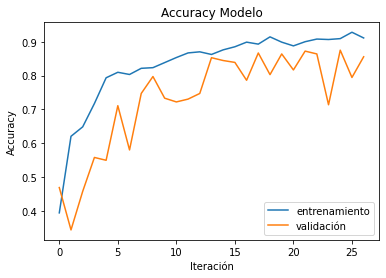

In [ ]:
# Gráfica de la métrica de precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()


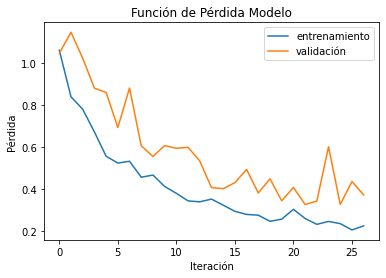

In [ ]:
# Gráfica de la función de pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de Pérdida Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='upper right')
plt.show()



---
###Evaluación del Modelo


---




In [ ]:
# Load Model
#El modelo se guarda en .h5 , el modelo no pesa mucho ya se puede enviar  y se puede cargar : 
model_loaded = load_model("/content/drive/My Drive/final/model_jupyter.h5")

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:

In [ ]:

#NO es predict como en sklearn si no un generador 
#SE utiliza un conjunto de prueba 
step_size_test=test_generator.n/test_generator.batch_size
result_evaluate =  model_loaded.evaluate_generator(test_generator,step_size_test,verbose=1)
print(result_evaluate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

In [ ]:
#Ver la salidad , para saber de que clases es : 
y_pred_prob =  model_loaded.predict_generator(test_generator, steps= step_size_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
#Ver la categoria 
test_labels_one_hot = to_categorical(test_generator.classes)


NameError: ignored

In [ ]:
#Nos entrega probabilidades de cual es 
print(y_pred_prob)
print(y_pred_classes)
print(test_labels_one_hot)

[[9.91045535e-01 4.40913066e-03 4.54529701e-03]
 [9.82927024e-01 1.57862455e-02 1.28670328e-03]
 [9.36140835e-01 4.41279821e-02 1.97311342e-02]
 [9.62313175e-01 1.37378965e-02 2.39489507e-02]
 [6.84678912e-01 5.20604290e-03 3.10115010e-01]
 [9.80953038e-01 1.79691277e-02 1.07783370e-03]
 [9.81984556e-01 1.57483853e-02 2.26706010e-03]
 [3.12676281e-01 4.73781139e-01 2.13542566e-01]
 [8.26050818e-01 7.12578511e-03 1.66823387e-01]
 [4.61950839e-01 1.14923324e-02 5.26556790e-01]
 [9.78129864e-01 9.60022304e-03 1.22699235e-02]
 [9.65410709e-01 1.63716562e-02 1.82176903e-02]
 [7.56950140e-01 4.54077162e-02 1.97642118e-01]
 [8.90433371e-01 6.75448477e-02 4.20217291e-02]
 [9.99034405e-01 6.56673685e-04 3.08982242e-04]
 [9.91815865e-01 7.37359375e-03 8.10487138e-04]
 [9.78372514e-01 1.51118748e-02 6.51555695e-03]
 [9.99938011e-01 4.05007486e-05 2.14352476e-05]
 [9.82778370e-01 1.03240525e-02 6.89760176e-03]
 [9.64839041e-01 1.41596263e-02 2.10013222e-02]
 [9.64861810e-01 3.26234475e-02 2.514646

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_12904 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_12904 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_12904 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_12904 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


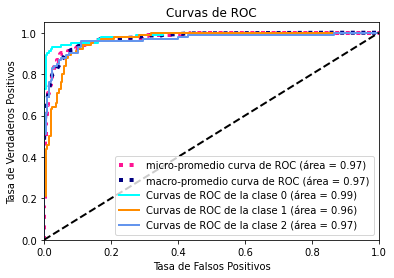

In [ ]:
#Taller opcional Parte 1

y_pred_prob =  model_loaded.predict_generator(test_generator, steps= step_size_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
test_labels_one_hot = to_categorical(test_generator.classes)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot((fpr["micro"]), (tpr["micro"]),
         label='micro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curvas de ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas de ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_generator.classes, y_pred_classes)
print('Accuracy: %f' % accuracy)


Accuracy: 0.866667


In [ ]:
print(test_generator.classes)
print(y_pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
[0 0 0 0 2 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 0 0 0 0 0 0 2 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1
 1 1 1 1 1 2 1 

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Precision:', precision)


Precision: 0.8941516673475437


In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(test_generator.classes, y_pred_classes, average = 'macro')
print('Recall: %f' % recall)

Recall: 0.893333


In [ ]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_generator.classes, y_pred_classes, average = 'macro')
print('F1 score: %f' % f1)

F1 score: 0.893556


In [ ]:
# kappa
kappa = cohen_kappa_score(test_generator.classes, y_pred_classes)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.840000


In [ ]:
# confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred_classes)
print(matrix)

[[93  4  3]
 [ 5 88  7]
 [ 1 12 87]]


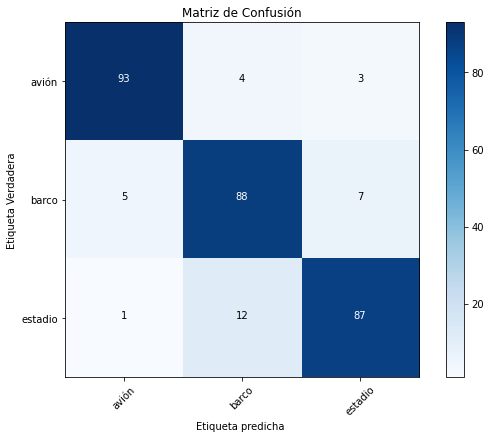

In [ ]:
#Taller opcional Parte 2

cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest',cmap=cmap)
plt.title("Matriz de Confusión")
plt.colorbar()
target_names = ['avión', 'barco', 'estadio']

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)



thresh = matrix.max() / 1.5
matrix.max() / 2
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, "{:,}".format(matrix[i, j]),horizontalalignment="center",color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta predicha ')
plt.show()